# load stuff for inference

## Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Test set Image Processing

In [3]:
test_set = tf.keras.utils.image_dataset_from_directory(
    'Test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True
)
class_name = test_set.class_names
print(class_name)

Found 20903 files belonging to 24 classes.
['fresh_Apple', 'fresh_Banana', 'fresh_Bittergroud', 'fresh_Capsicum', 'fresh_Cucumber', 'fresh_Guava', 'fresh_Lime', 'fresh_Okra', 'fresh_Oranges', 'fresh_Pomegranate', 'fresh_Potato', 'fresh_Tomato', 'rottenApple', 'rottenBanana', 'rottenBittergroud', 'rottenCapsicum', 'rottenCucumber', 'rottenGuava', 'rottenLime', 'rottenOkra', 'rottenOrange', 'rottenPomegranate', 'rottenPotato', 'rottenTomato']


## Loading Model

In [5]:
cnn = tf.keras.models.load_model('trained_food_model.keras')

## Inference on a random image

In [7]:
conf_thresh = 80
not_found_count = 0

In [8]:
# load all image paths
import os
import random

# Set the path to the "Test" folder
test_folder = 'Test'  # Make sure to set the correct path if it's not in the same directory

# List to store all image file paths
image_paths = []

# Image file extension to search for (only jpg images)
image_extension = '.jpg'

# Traverse the directory tree recursively using os.walk()
for root, dirs, files in os.walk(test_folder):
    for file in files:
        if file.lower().endswith(image_extension):
            # Get the full path of the image
            image_paths.append(os.path.join(root, file))

Random image path: Test\rottenGuava\IMG_20190822_080915_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
highest prediction: rottenGuava(17) with 100.000% confidence


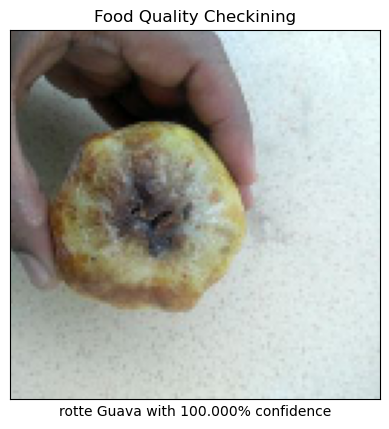

In [9]:
# Get a random item from the list
# Check if any image paths are found
if not image_paths:
    print("No .jpg image files found in the folder or its subfolders.")
else:
    # Pick a random image from the list
    image_path = random.choice(image_paths)
    
    # Print the random image path
    print("Random image path:", image_path)

image = tf.keras.preprocessing.image.load_img(image_path,target_size=(128,128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = cnn.predict(input_arr)

# display the prediction
result_index = np.argmax(predictions) #Return index of max element
conf = predictions[0][result_index]*100

model_prediction = class_name[result_index]
quality=model_prediction[:5]
name=model_prediction[6:]
plt.imshow(image)
plt.xticks([])
plt.yticks([])

plt.title("Food Quality Checkining")
if conf > conf_thresh:
    print(f"highest prediction: {class_name[result_index]}({result_index}) with {conf:.3f}% confidence")
    plt.xlabel(f"{quality} {name} with {conf:.3f}% confidence")
    plt.show()
else: 
    print(f"no food found => {class_name[result_index]}({conf:.3f}) < conf_thresh({conf_thresh})")    
    plt.xlabel("food not found boss!")
    plt.show()


highest prediction: rottenGuava(17) with 100.000% confidence


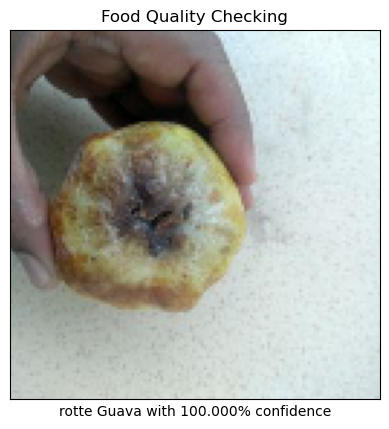

In [10]:
# display the prediction
result_index = np.argmax(predictions) #Return index of max element
conf = predictions[0][result_index]*100

model_prediction = class_name[result_index]
quality=model_prediction[:5]
name=model_prediction[6:]
plt.imshow(image)
plt.xticks([])
plt.yticks([])

plt.title("Food Quality Checking")
if conf > conf_thresh:
    print(f"highest prediction: {class_name[result_index]}({result_index}) with {conf:.3f}% confidence")
    plt.xlabel(f"{quality} {name} with {conf:.3f}% confidence")
    plt.show()
else: 
    print(f"no food found => {class_name[result_index]}({conf:.3f}) < conf_thresh({conf_thresh})")    
    plt.xlabel("food not found boss!")
    plt.show()

# Inference with camera

## text to speech function

### blocking speech

In [14]:
import pyttsx3
import time

# Initialize the text-to-speech engine
engine = pyttsx3.init()

# Set properties (optional)
engine.setProperty('rate', 180)  # Speed
engine.setProperty('volume', 0.9)  # Volume (0.0 to 1.0)

# Enter the text to be spoken
text = "Hello Boss! I'm your virtual assistance, Let's start seperating the good and bad fruits"

# Convert text to speech
def speak(text):
    engine.say(text)
    engine.runAndWait()    

speak(text)

### non-blocking speech

In [16]:
import pyttsx3
import threading
import queue
import time

# Define a queue to hold text inputs
text_queue = queue.Queue()

# Flag to track whether the engine is speaking
speech_engine_status = 0  # 0 = idle, 1 = speaking

# Function to handle speech asynchronously
def speak_in_async():
    # Initialize the text-to-speech engine
    engine = pyttsx3.init()
    
    # Set properties (optional)
    engine.setProperty('rate', 180)  # Speed
    engine.setProperty('volume', 0.9)  # Volume (0.0 to 1.0)

    global speech_engine_status
    while True:
        text = text_queue.get()  # Wait for the next text input
        print("text: ", text)
        if text == "STOP":  # Special condition to stop the thread
            break
        
        # print(f"Speaking: {text}")
        engine.stop()  # Stop any ongoing speech
        speech_engine_status = 1  # Mark as speaking
        engine.say(text)  # Start speaking asynchronously
        engine.runAndWait()
    
    # Stop the engine after processing the "STOP" signal
    print("Shutting down the speech engine.")
    engine.stop()

# Start the speak thread
speak_thread = threading.Thread(target=speak_in_async, daemon=True)
speak_thread.start()

def speak_without_block(message):
    text_queue.put(message)

def end_speech_engine():
    text_queue.put("STOP")  # Signal the speak thread to stop
    speak_thread.join()  # Wait for the thread to finish    


In [17]:
# # Main loop running at 20 Hz
# try:
#     for i in range(1, 21):  # Example: running for 20 iterations at 20 Hz
#         message = f"Message number {i}"
#         print(message)
#         if i%3 ==0:
#             speak_without_block(message)  # Add the message to the queue
#         time.sleep(0.5)  # 2 seconds interval

# finally:
#     print("End of the test")


## Connect Arduino

In [19]:
import serial
import serial.tools.list_ports
import time

# Function to find and connect to the device
def connect_to_device(desired_port, baud_rate=9600):
    while True:
        try:
            # Check if the desired port is available
            ports = serial.tools.list_ports.comports()
            available_ports = [port.device for port in ports]

            if desired_port in available_ports:
                print(f"Arduino found on {desired_port}. Connecting...")
                speak(f"Arduino found on {desired_port}. Connecting...")
                arduino = serial.Serial(desired_port, baud_rate)
                # time.sleep(2)  # Wait for the connection to stabilize
                print(f"Successfully connected to {desired_port}")
                speak(f"Successfully connected to {desired_port}")
                return arduino
            else:
                print(f"Arduino not found on {desired_port}. please connect the device, I'm Retrying...")
                speak(f"Arduino not found on {desired_port}. please connect the device, I'm Retrying...")
                time.sleep(1)
        except serial.SerialException as e:
            print(f"Error connecting to {desired_port}: {e}")
            speak(f"Error connecting to {desired_port}: {e}")
            time.sleep(1)

# Main code
desired_port = "COM3"
arduino = connect_to_device(desired_port)

# Function to send commands
def send_command(status, quality, name, conf):
    if arduino.is_open:
        arduino.write(f'{status}\n'.encode())  # Send the status
        result_text = f"found {quality} {name} with {conf:.3f}% confidence so, I sent {status} to arduino"
        print(result_text)
        speak(result_text)
        
        # # Optional: Read response from Arduino
        # response = arduino.readline().decode().strip()
        # print(f"Arduino response: {response}")
    else:
        print("Serial port is not open.")
        speak("Serial port is not open.")


Arduino found on COM3. Connecting...
Successfully connected to COM3


## function to display prediction

In [21]:
# Displaying the disease prediction
def display_pred(image, conf):
    model_prediction = class_name[result_index]
    quality=model_prediction[:5]
    name=model_prediction[6:]
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    global not_found_count
    
    plt.title("Food Quality Checkining")
    if conf > conf_thresh:
        plt.xlabel(f"{quality} {name} with {conf:.3f}% confidence")
        plt.show()
        
        # to speak the result
        if not_found_count != 0:
            send_command("good" if quality=="fresh" else "bad", quality, name, conf) # to send command to arduino using serial port
        not_found_count = 0
    else: 
        plt.xlabel("food not found boss!")
        plt.show()
        
        # to speak the result
        if not_found_count != 1:
            speak("food not found boss!")  
        not_found_count = 1
    

## function to inference on image

In [23]:
def infer(image):
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = cnn.predict(input_arr)
    #printing the result
    result_index = np.argmax(predictions) #Return index of max element
    conf = predictions[0][result_index]*100
    if conf > conf_thresh:
        print(f"highest prediction: {class_name[result_index]}({result_index}) with {conf:.3f}% confidence")
    else: 
        print(f"no food found => {class_name[result_index]}({conf:.3f}) < conf_thresh({conf_thresh})")    
    
    # print(f"correct: prediction of {class_name[desired_index]}({desired_index}) =  {predictions[0][desired_index]}")
    return image, result_index, conf
    

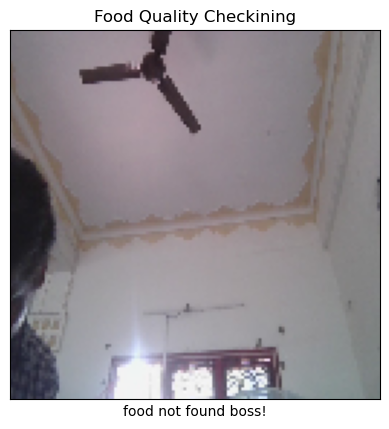

In [ ]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Initialize the webcam (0 is typically the default camera)
cap = cv2.VideoCapture(0)

# Create a figure for displaying the camera feed
plt.ion()  # Turn on interactive mode for live updates

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # If the frame is read correctly, ret will be True
    if not ret:
        print("Failed to grab frame")
        break
    
    # Convert the frame from BGR (OpenCV default) to RGB (matplotlib default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Resize the frame to match the model's input size
    target_size = (128, 128)  # Adjust according to your model's input size
    resized_frame = cv2.resize(frame_rgb, target_size)
    
    # Process the resized frame for inference
    processed_image, result_index, confidence = infer(resized_frame)
    
    # Clear the previous output (this creates the effect of "queueing" frames)
    clear_output(wait=True)
    
    # Display the frame with prediction and confidence
    display_pred(processed_image, confidence)
    
    # Pause for a brief moment to allow the display to update
    time.sleep(0.1)
    
    # Check for key press to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
        print("Exiting...")
        break

# Release the camera when done
cap.release()
cv2.destroyAllWindows()


In [ ]:
# # added some code to get the delay between each function execution
# import cv2
# import matplotlib.pyplot as plt
# from IPython.display import display, clear_output
# import time

# # Initialize the webcam (0 is typically the default camera)
# cap = cv2.VideoCapture(0)

# # Create a figure for displaying the camera feed
# plt.ion()  # Turn on interactive mode for live updates

# while True:
#     start_time = time.time()  # Start the timer for the loop
    
#     # Capture frame-by-frame
#     t1 = time.time()
#     ret, frame = cap.read()
#     t2 = time.time()
    
#     if not ret:
#         print("Failed to grab frame")
#         break
    
#     # Convert the frame from BGR (OpenCV default) to RGB (matplotlib default)
#     t3 = time.time()
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     t4 = time.time()
    
#     # Resize the frame to match the model's input size
#     t5 = time.time()
#     target_size = (128, 128)  # Adjust according to your model's input size
#     resized_frame = cv2.resize(frame_rgb, target_size)
#     t6 = time.time()
    
#     # Process the resized frame for inference
#     t7 = time.time()
#     processed_image, result_index, confidence = infer(resized_frame)
#     t8 = time.time()
    
#     # Clear the previous output
#     t9 = time.time()
#     clear_output(wait=True)
#     t10 = time.time()
    
#     # Display the frame with prediction and confidence
#     t11 = time.time()
#     display_pred(processed_image, confidence)
#     t12 = time.time()
    
#     # Log times for each function
#     print(f"Time for grabbing frame: {t2 - t1:.4f} seconds")
#     print(f"Time for color conversion: {t4 - t3:.4f} seconds")
#     print(f"Time for resizing: {t6 - t5:.4f} seconds")
#     print(f"Time for inference: {t8 - t7:.4f} seconds")
#     print(f"Time for clearing output: {t10 - t9:.4f} seconds")
#     print(f"Time for displaying prediction: {t12 - t11:.4f} seconds")
#     print(f"Total loop time: {time.time() - start_time:.4f} seconds")

#     # Pause for a brief moment to allow the display to update
#     # time.sleep(0.1)
#     # Check for key press to exit the loop
#     if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
#         print("Exiting...")
#         break

# # Release the camera when done
# cap.release()
# cv2.destroyAllWindows()
